In [18]:
%matplotlib inline
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.visual import plot_spectrogram
from TTS.utils.io import load_config
import IPython.display as ipd
import glob 
import random

In [2]:
config_path = "C:\\Users\\julia\\workspace\\train\\config.json"
data_path = "C:\\Users\\julia\\workspace\\VCTK-Corpus"
file_paths = glob.glob(data_path + "/**/*.wav", recursive=True)
CONFIG = load_config(config_path)

### Setup Audio Processor
Play with the AP parameters until you find a good fit with the synthesis speech below. 

In [250]:
CONFIG.audio['trim_db'] = 18
AP = AudioProcessor(**CONFIG.audio);

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:50.0
 | > mel_fmax:7600.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:18
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:256
 | > win_length:1024


### Check audio loading 

In [202]:
i = random.randint(0,len(file_paths)-1)
i

24667

In [360]:
wav = AP.load_wav(file_paths[i])
ipd.Audio(data=wav, rate=AP.sample_rate)

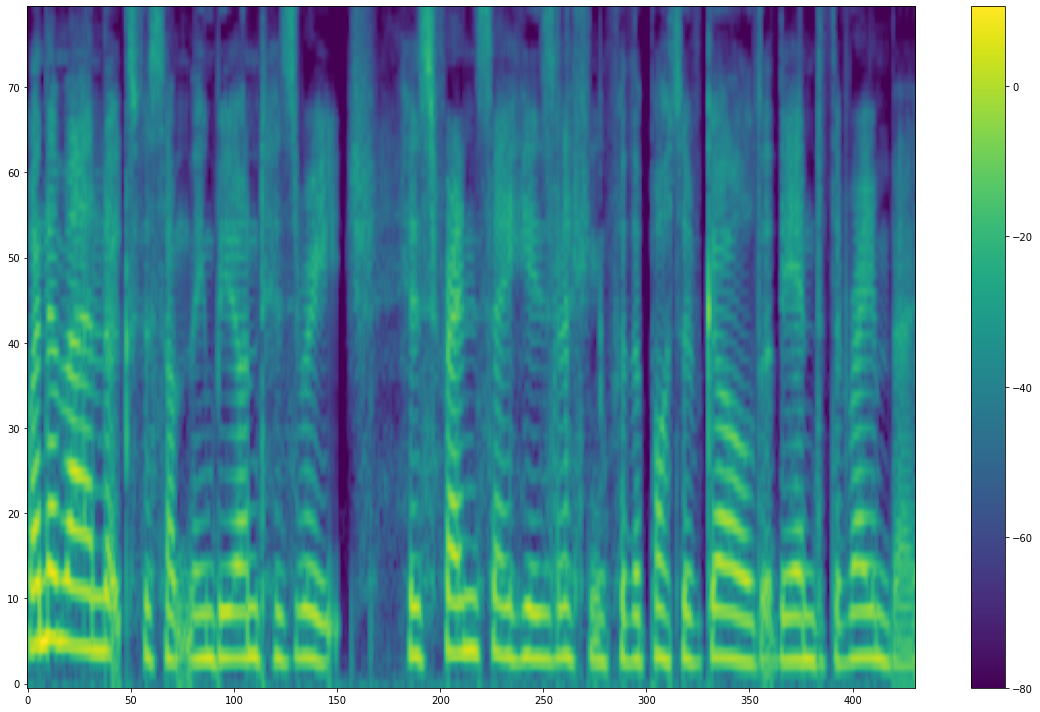

In [361]:
plot_spectrogram(mel.T, AP)

### Generate Mel-Spectrogram and Re-synthesis with GL

In [28]:
AP.power = 1.0

In [6]:
mel = AP.melspectrogram(wav)
print("Max:", mel.max())
print("Min:", mel.min())
print("Mean:", mel.mean())
plot_spectrogram(mel.T, AP)

wav_gen = AP.inv_melspectrogram(mel)
ipd.Audio(wav_gen, rate=AP.sample_rate)

Max: 3.3729982
Min: -4.0
Mean: -0.97611


### Generate Linear-Spectrogram and Re-synthesis with GL

In [18]:
spec = AP.spectrogram(wav)
print("Max:", spec.max())
print("Min:", spec.min())
print("Mean:", spec.mean())
plot_spectrogram(spec.T, AP);

wav_gen = AP.inv_spectrogram(spec)
ipd.Audio(wav_gen, rate=AP.sample_rate)

RuntimeError:  [!] Mean-Var stats does not match the given feature dimensions.

### Compare values for a certain parameter

Optimize your parameters by comparing different values per parameter at a time.

In [ ]:
audio={
 'audio_processor': 'audio',
 'num_mels': 80,          # In general, you don'tneed to change it 
 'num_freq': 1025,        # In general, you don'tneed to change it 
 'sample_rate': 22050,    # It depends to the sample rate of the dataset.
 'frame_length_ms': 50,   # In general, you don'tneed to change it 
 'frame_shift_ms': 12.5,  # In general, you don'tneed to change it 
 'preemphasis': 0.98,        # In general, 0 gives better voice recovery but makes traning harder. If your model does not train, try 0.97 - 0.99.
 'min_level_db': -100,
 'ref_level_db': 20,      # It is the base DB, higher until you remove the background noise in the spectrogram and then lower until you hear a better speech below.
 'power': 1.5,            # Change this value and listen the synthesized voice. 1.2 - 1.5 are some resonable values.
 'griffin_lim_iters': 60, # It does not give any imporvement for values > 60
 'signal_norm': True,     # This is more about your model. It does not give any change for the synthsis performance.
 'symmetric_norm': False,   # Same as above
 'max_norm': 1,           # Same as above
 'clip_norm': True,       # Same as above
 'mel_fmin': 0.0,        # You can play with this and check mel-spectrogram based voice synthesis below.
 'mel_fmax': 8000.0,        # You can play with this and check mel-spectrogram based voice synthesis below.
 'do_trim_silence': True} # If you dataset has some silience at the beginning or end, this trims it. Check the AP.load_wav() below,if it causes any difference for the loaded audio file.

AP = AudioProcessor(**audio);

In [ ]:
from librosa import display
from matplotlib import pylab as plt
import IPython
plt.rcParams['figure.figsize'] = (20.0, 16.0)

def compare_values(attribute, values, file):
    """
    attributes (str): the names of the attribute you like to test.
    values (list): list of values to compare.
    file (str): file name to perform the tests.
    """
    wavs = []
    for idx, val in enumerate(values):
        set_val_cmd = "AP.{}={}".format(attribute, val)
        exec(set_val_cmd)
        wav = AP.load_wav(file)
        spec = AP.spectrogram(wav)
        spec_norm = AP.denormalize(spec.T)
        plt.subplot(len(values), 2, 2*idx + 1)
        plt.imshow(spec_norm.T, aspect="auto", origin="lower")
        #         plt.colorbar()
        plt.tight_layout()
        wav_gen = AP.inv_spectrogram(spec)
        wavs.append(wav_gen)
        plt.subplot(len(values), 2, 2*idx + 2)
        display.waveplot(wav, alpha=0.5)
        display.waveplot(wav_gen, alpha=0.25)
        plt.title("{}={}".format(attribute, val))
        plt.tight_layout()
    
    wav = AP.load_wav(file)
    print(" > Ground-truth")
    IPython.display.display(IPython.display.Audio(wav, rate=AP.sample_rate))
    
    for idx, wav_gen in enumerate(wavs):
        val = values[idx]
        print(" > {} = {}".format(attribute, val))
        IPython.display.display(IPython.display.Audio(wav_gen, rate=AP.sample_rate))

In [ ]:
compare_values("preemphasis", [0, 0.5, 0.97, 0.98, 0.99], file_paths[10])

In [ ]:
compare_values("ref_level_db", [10, 15, 20, 25, 30, 35, 40], file_paths[10])